# Face Generation

In this project, you'll define and train a DCGAN on a dataset of faces. Your goal is to get a generator network to generate *new* images of faces that look as realistic as possible!

The project will be broken down into a series of tasks from **loading in data to defining and training adversarial networks**. At the end of the notebook, you'll be able to visualize the results of your trained Generator to see how it performs; your generated samples should look like fairly realistic faces with small amounts of noise.

### Get the Data

You'll be using the [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) to train your adversarial networks.

This dataset is more complex than the number datasets (like MNIST or SVHN) you've been working with, and so, you should prepare to define deeper networks and train them for a longer time to get good results. It is suggested that you utilize a GPU for training.

### Pre-processed Data

Since the project's main focus is on building the GANs, we've done *some* of the pre-processing for you. Each of the CelebA images has been cropped to remove parts of the image that don't include a face, then resized down to 64x64x3 NumPy images. Some sample data is show below.

<img src='assets/processed_face_data.png' width=60% />

> If you are working locally, you can download this data [by clicking here](https://s3.amazonaws.com/video.udacity-data.com/topher/2018/November/5be7eb6f_processed-celeba-small/processed-celeba-small.zip)

This is a zip file that you'll need to extract in the home directory of this notebook for further loading and processing. After extracting the data, you should be left with a directory of data `processed_celeba_small/`

In [4]:
# can comment out after executing
# !unzip processed_celeba_small.zip

In [5]:
data_dir = 'processed_celeba_small/'

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import pickle as pkl
import matplotlib.pyplot as plt
import numpy as np
import problem_unittests as tests
#import helper

%matplotlib inline

## Visualize the CelebA Data

The [CelebA](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations. Since you're going to be generating faces, you won't need the annotations, you'll only need the images. Note that these are color images with [3 color channels (RGB)](https://en.wikipedia.org/wiki/Channel_(digital_image)#RGB_Images) each.

### Pre-process and Load the Data

Since the project's main focus is on building the GANs, we've done *some* of the pre-processing for you. Each of the CelebA images has been cropped to remove parts of the image that don't include a face, then resized down to 64x64x3 NumPy images. This *pre-processed* dataset is a smaller subset of the very large CelebA data.

> There are a few other steps that you'll need to **transform** this data and create a **DataLoader**.

#### Exercise: Complete the following `get_dataloader` function, such that it satisfies these requirements:

* Your images should be square, Tensor images of size `image_size x image_size` in the x and y dimension.
* Your function should return a DataLoader that shuffles and batches these Tensor images.

#### ImageFolder

To create a dataset given a directory of images, it's recommended that you use PyTorch's [ImageFolder](https://pytorch.org/docs/stable/torchvision/datasets.html#imagefolder) wrapper, with a root directory `processed_celeba_small/` and data transformation passed in.

In [6]:
# necessary imports
import torch
from torchvision import datasets
from torchvision import transforms

In [7]:
def get_dataloader(batch_size, image_size, data_dir='processed_celeba_small/'):
    """
    Batch the neural network data using DataLoader
    :param batch_size: The size of each batch; the number of images in a batch
    :param img_size: The square size of the image data (x, y)
    :param data_dir: Directory where image data is located
    :return: DataLoader with batched data
    """
    
    # TODO: Implement function and return a dataloader
    
    # Tensor transform
    transform = transforms.Compose([
        transforms.Resize(image_size),
        transforms.ToTensor()])

    # CelebA datasets
    celebA_dataset = datasets.ImageFolder(root=data_dir, transform=transform)
  
    # CelebA dataloader
    dataloader = torch.utils.data.DataLoader(dataset=celebA_dataset,
                                             batch_size=batch_size,
                                             shuffle=True,
                                             num_workers=0)
    return dataloader

## Create a DataLoader

#### Exercise: Create a DataLoader `celeba_train_loader` with appropriate hyperparameters.

Call the above function and create a dataloader to view images. 
* You can decide on any reasonable `batch_size` parameter
* Your `image_size` **must be** `32`. Resizing the data to a smaller size will make for faster training, while still creating convincing images of faces!

In [8]:
# Define function hyperparameters
batch_size = 32
img_size = 32

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
# Call your function and get a dataloader
celeba_train_loader = get_dataloader(batch_size, img_size)


Next, you can view some images! You should seen square images of somewhat-centered faces.

Note: You'll need to convert the Tensor images into a NumPy type and transpose the dimensions to correctly display an image, suggested `imshow` code is below, but it may not be perfect.

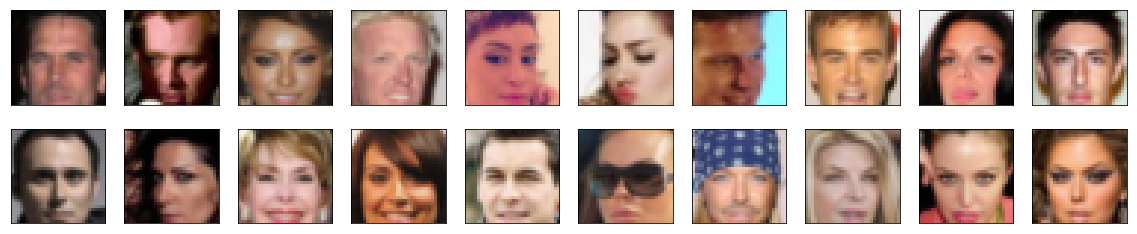

In [9]:
# helper display function
def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
# obtain one batch of training images
dataiter = iter(celeba_train_loader)
images, _ = dataiter.next() # _ for no labels

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(20, 4))
plot_size=20
for idx in np.arange(plot_size):
    ax = fig.add_subplot(2, plot_size/2, idx+1, xticks=[], yticks=[])
    imshow(images[idx])

#### Exercise: Pre-process your image data and scale it to a pixel range of -1 to 1

You need to do a bit of pre-processing; you know that the output of a `tanh` activated generator will contain pixel values in a range from -1 to 1, and so, we need to rescale our training images to a range of -1 to 1. (Right now, they are in a range from 0-1.)

In [10]:
# TODO: Complete the scale function
def scale(x, feature_range=(-1, 1)):
    ''' Scale takes in an image x and returns that image, scaled
       with a feature_range of pixel values from -1 to 1. 
       This function assumes that the input x is already scaled from 0-1.'''
    # assume x is scaled to (0, 1)
    # scale to feature_range and return scaled x
    x = x * (feature_range[1] - feature_range[0]) + feature_range[0]
   
    return x


In [11]:
"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
# check scaled range
# should be close to -1 to 1
img = images[0]
scaled_img = scale(img)

print('Min: ', scaled_img.min())
print('Max: ', scaled_img.max())

Min:  tensor(-0.9922)
Max:  tensor(0.7882)


---
# Define the Model

A GAN is comprised of two adversarial networks, a discriminator and a generator.

## Discriminator

Your first task will be to define the discriminator. This is a convolutional classifier like you've built before, only without any maxpooling layers. To deal with this complex data, it's suggested you use a deep network with **normalization**. You are also allowed to create any helper functions that may be useful.

#### Exercise: Complete the Discriminator class
* The inputs to the discriminator are 32x32x3 tensor images
* The output should be a single value that will indicate whether a given image is real or fake


In [12]:
import torch.nn as nn
import torch.nn.functional as F

In [13]:
# helper conv function
def conv(in_channels, out_channels, kernel_size, stride=2, padding=1, batch_norm=True):
    """Creates a convolutional layer, with optional batch normalization.
    """
    layers = []
    conv_layer = nn.Conv2d(in_channels, out_channels, 
                           kernel_size, stride, padding, bias=False)
    
    # append conv layer
    layers.append(conv_layer)

    if batch_norm:
        # append batchnorm layer
        layers.append(nn.BatchNorm2d(out_channels))
     
    # using Sequential container
    return nn.Sequential(*layers)

In [14]:
class Discriminator(nn.Module):

    def __init__(self, conv_dim):
        """
        Initialize the Discriminator Module
        :param conv_dim: The depth of the first convolutional layer
        """
        super(Discriminator, self).__init__()

        self.conv_dim = conv_dim   
        self.conv1 = conv(3, conv_dim, kernel_size=4, batch_norm=False) #first layer no batch_norm
        self.conv2 = conv(conv_dim, conv_dim*2, kernel_size=4, batch_norm=True)
        self.conv3 = conv(conv_dim*2, conv_dim*4, kernel_size=4, batch_norm=True)
        self.fc = nn.Linear((conv_dim*4)*4*4, 1)

    def forward(self, x):
        """
        Forward propagation of the neural network
        :param x: The input to the neural network     
        :return: Discriminator logits; the output of the neural network
        """
        # define feedforward behavior
        x = F.leaky_relu(self.conv1(x), negative_slope=0.2)
        x = F.leaky_relu(self.conv2(x), negative_slope=0.2)
        x = F.leaky_relu(self.conv3(x), negative_slope=0.2)
        
        x = x.view(-1,(self.conv_dim*4)*4*4) 
        
        x = self.fc(x)
        
        
        return x


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(Discriminator)

Tests Passed


## Generator

The generator should upsample an input and generate a *new* image of the same size as our training data `32x32x3`. This should be mostly transpose convolutional layers with normalization applied to the outputs.

#### Exercise: Complete the Generator class
* The inputs to the generator are vectors of some length `z_size`
* The output should be a image of shape `32x32x3`

In [15]:
# helper deconv function
def deconv(in_channels, out_channels, kernel_size, stride=2, padding=1, batch_norm=True):
    """Creates a transposed-convolutional layer, with optional batch normalization.
    """
    ## create a sequence of transpose + optional batch norm layers
    layers = []
    transpose_conv_layer = nn.ConvTranspose2d(in_channels, out_channels, 
                                              kernel_size, stride, padding, bias=False)
    
    # append conv layer
    layers.append(transpose_conv_layer)

    if batch_norm:
        # append batchnorm layer
        layers.append(nn.BatchNorm2d(out_channels))
     
    # using Sequential container
    return nn.Sequential(*layers)

In [16]:
class Generator(nn.Module):
    
    def __init__(self, z_size, conv_dim):
        """
        Initialize the Generator Module
        :param z_size: The length of the input latent vector, z
        :param conv_dim: The depth of the inputs to the *last* transpose convolutional layer
        """
        super(Generator, self).__init__()

        self.conv_dim = conv_dim
        self.fc = nn.Linear(z_size, (conv_dim*4)*4*4)
        self.t_conv1 = deconv(4*conv_dim, 2*conv_dim, kernel_size=4) 
        self.t_conv2 = deconv(2*conv_dim, conv_dim, kernel_size=4)
        self.t_conv3 = deconv(conv_dim, 3, kernel_size=4,batch_norm=False)  
        
    def forward(self, x):
        """
        Forward propagation of the neural network
        :param x: The input to the neural network     
        :return: A 32x32x3 Tensor image as output
        """
        # define feedforward behavior
        x = self.fc(x)
        
        x = x.view(-1, self.conv_dim*4,4,4)
        
        x = F.relu(self.t_conv1(x))
        x = F.relu(self.t_conv2(x))
        
        x = self.t_conv3(x)
        x = F.tanh(x)
        
        return x

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(Generator)

Tests Passed


## Initialize the weights of your networks

To help your models converge, you should initialize the weights of the convolutional and linear layers in your model. From reading the [original DCGAN paper](https://arxiv.org/pdf/1511.06434.pdf), they say:
> All weights were initialized from a zero-centered Normal distribution with standard deviation 0.02.

So, your next task will be to define a weight initialization function that does just this!

You can refer back to the lesson on weight initialization or even consult existing model code, such as that from [the `networks.py` file in CycleGAN Github repository](https://github.com/junyanz/pytorch-CycleGAN-and-pix2pix/blob/master/models/networks.py) to help you complete this function.

#### Exercise: Complete the weight initialization function

* This should initialize only **convolutional** and **linear** layers
* Initialize the weights to a normal distribution, centered around 0, with a standard deviation of 0.02.
* The bias terms, if they exist, may be left alone or set to 0.

In [17]:
def weights_init_normal(m):
    """
    Applies initial weights to certain layers in a model .
    The weights are taken from a normal distribution 
    with mean = 0, std dev = 0.02.
    :param m: A module or layer in a network    
    """
    # classname will be something like:
    # `Conv`, `BatchNorm2d`, `Linear`, etc.
    def init_func(m):  # define the initialization function
        classname = m.__class__.__name__

        # TODO: Apply initial weights to convolutional and linear layers
        if hasattr(m, 'weight') and (classname.find('Conv') != -1 or classname.find('Linear') != -1):
            torch.nn.init.normal_(m.weight.data, 0.0, 0.02)

            if hasattr(m, 'bias') and m.bias is not None:
                torch.nn.init.constant_(m.bias.data, 0.0)
        elif classname.find('BatchNorm2d') != -1:  # BatchNorm Layer's weight is not a matrix; only normal distribution applies.
            torch.nn.init.normal_(m.weight.data, 1.0, 0.02)
            torch.nn.init.constant_(m.bias.data, 0.0)

    m.apply(init_func)  # apply the initialization function <init_func>

## Build complete network

Define your models' hyperparameters and instantiate the discriminator and generator from the classes defined above. Make sure you've passed in the correct input arguments.

In [18]:
"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
def build_network(d_conv_dim, g_conv_dim, z_size):
    # define discriminator and generator
    D = Discriminator(d_conv_dim)
    G = Generator(z_size=z_size, conv_dim=g_conv_dim)

    # initialize model weights
    D.apply(weights_init_normal)
    G.apply(weights_init_normal)

    print(D)
    print()
    print(G)
    
    return D, G


#### Exercise: Define model hyperparameters

In [19]:
# Define model hyperparams
d_conv_dim = 32
g_conv_dim = 32
z_size = 100

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
D, G = build_network(d_conv_dim, g_conv_dim, z_size)

Discriminator(
  (conv1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  )
  (conv2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv3): Sequential(
    (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (fc): Linear(in_features=2048, out_features=1, bias=True)
)

Generator(
  (fc): Linear(in_features=100, out_features=2048, bias=True)
  (t_conv1): Sequential(
    (0): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (t_conv2): Sequential(
    (0): ConvTranspose2d(64, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias

### Training on GPU

Check if you can train on GPU. Here, we'll set this as a boolean variable `train_on_gpu`. Later, you'll be responsible for making sure that 
>* Models,
* Model inputs, and
* Loss function arguments

Are moved to GPU, where appropriate.

In [20]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import torch

# Check for a GPU
train_on_gpu = torch.cuda.is_available()
if not train_on_gpu:
    print('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Training on GPU!')

Training on GPU!


---
## Discriminator and Generator Losses

Now we need to calculate the losses for both types of adversarial networks.

### Discriminator Losses

> * For the discriminator, the total loss is the sum of the losses for real and fake images, `d_loss = d_real_loss + d_fake_loss`. 
* Remember that we want the discriminator to output 1 for real images and 0 for fake images, so we need to set up the losses to reflect that.


### Generator Loss

The generator loss will look similar only with flipped labels. The generator's goal is to get the discriminator to *think* its generated images are *real*.

#### Exercise: Complete real and fake loss functions

**You may choose to use either cross entropy or a least squares error loss to complete the following `real_loss` and `fake_loss` functions.**

In [21]:
def real_loss(D_out):
    '''Calculates how close discriminator outputs are to being real.
       param, D_out: discriminator logits
       return: real loss'''
    batch_size = D_out.size(0)
    # label smoothing
    # smooth, real labels = 0.9
    labels = torch.ones(batch_size)*0.9

    # move labels to GPU if available     
    if train_on_gpu:
        labels = labels.cuda()
    # binary cross entropy with logits loss
    criterion = nn.BCEWithLogitsLoss()
    # calculate loss
    loss = criterion(D_out.squeeze(), labels)
    
    return loss

def fake_loss(D_out):
    '''Calculates how close discriminator outputs are to being fake.
       param, D_out: discriminator logits
       return: fake loss'''
    batch_size = D_out.size(0)
    labels = torch.zeros(batch_size) # fake labels = 0
    if train_on_gpu:
        labels = labels.cuda()
    criterion = nn.BCEWithLogitsLoss()
    # calculate loss
    loss = criterion(D_out.squeeze(), labels)
    
    return loss

## Optimizers

#### Exercise: Define optimizers for your Discriminator (D) and Generator (G)

Define optimizers for your models with appropriate hyperparameters.

In [22]:
import torch.optim as optim

# Create optimizers for the discriminator D and generator G

# params
lr = 0.0002
beta1=0.5
beta2=0.999

# Create optimizers for the discriminator and generator
d_optimizer = optim.Adam(D.parameters(), lr, [beta1, beta2])
g_optimizer = optim.Adam(G.parameters(), lr, [beta1, beta2])

---
## Training

Training will involve alternating between training the discriminator and the generator. You'll use your functions `real_loss` and `fake_loss` to help you calculate the discriminator losses.

* You should train the discriminator by alternating on real and fake images
* Then the generator, which tries to trick the discriminator and should have an opposing loss function


#### Saving Samples

You've been given some code to print out some loss statistics and save some generated "fake" samples.

#### Exercise: Complete the training function

Keep in mind that, if you've moved your models to GPU, you'll also have to move any model inputs to GPU.

In [23]:
def train(D, G, n_epochs, print_every=50):
    '''Trains adversarial networks for some number of epochs
       param, D: the discriminator network
       param, G: the generator network
       param, n_epochs: number of epochs to train for
       param, print_every: when to print and record the models' losses
       return: D and G losses'''
    
    # move models to GPU
    if train_on_gpu:
        D.cuda()
        G.cuda()

    # keep track of loss and generated, "fake" samples
    samples = []
    losses = []

    # Get some fixed data for sampling. These are images that are held
    # constant throughout training, and allow us to inspect the model's performance
    sample_size=16
    fixed_z = np.random.uniform(-1, 1, size=(sample_size, z_size))
    fixed_z = torch.from_numpy(fixed_z).float()
    # move z to GPU if available
    if train_on_gpu:
        fixed_z = fixed_z.cuda()

    # epoch training loop
    for epoch in range(n_epochs):

        # batch training loop
        for batch_i, (real_images, _) in enumerate(celeba_train_loader):

            batch_size = real_images.size(0)
            real_images = scale(real_images)

            # ===============================================
            #         YOUR CODE HERE: TRAIN THE NETWORKS
            # ===============================================
            d_optimizer.zero_grad()
            g_optimizer.zero_grad()
            
            # 1. Train the discriminator on real and fake images
            
            # Compute the discriminator losses on real images 
            if train_on_gpu:
                real_images = real_images.cuda()
        
            D_real = D(real_images)
            d_real_loss = real_loss(D_real)
            
            # Generate fake images
            z = np.random.uniform(-1, 1, size=(batch_size, z_size))
            z = torch.from_numpy(z).float()
            # move z to GPU, if available
            if train_on_gpu:
                z = z.cuda()
            fake_images = G(z)
            # Compute the discriminator losses on fake images 
            D_fake = D(fake_images)
            d_fake_loss = fake_loss(D_fake)
            
            d_loss = d_real_loss + d_fake_loss
            d_loss.backward()
            d_optimizer.step() 

            # 2. Train the generator with an adversarial loss
            
            # Generate fake images
            z = np.random.uniform(-1, 1, size=(batch_size, z_size))
            z = torch.from_numpy(z).float()
            if train_on_gpu:
                z = z.cuda()
            fake_images = G(z)
            
            # Compute the discriminator losses on fake images 
            # using flipped labels!
            D_fake = D(fake_images)
            g_loss = real_loss(D_fake) # use real loss to flip labels

            # perform backprop
            g_loss.backward()
            g_optimizer.step()            
            
            # ===============================================
            #              END OF YOUR CODE
            # ===============================================

            # Print some loss stats
            if batch_i % print_every == 0:
                # append discriminator loss and generator loss
                losses.append((d_loss.item(), g_loss.item()))
                # print discriminator and generator loss
                print('Epoch [{:5d}/{:5d}] | d_loss: {:6.4f} | g_loss: {:6.4f}'.format(
                        epoch+1, n_epochs, d_loss.item(), g_loss.item()))


        ## AFTER EACH EPOCH##    
        # this code assumes your generator is named G, feel free to change the name
        # generate and save sample, fake images
        G.eval() # for generating samples
        samples_z = G(fixed_z)
        samples.append(samples_z)
        G.train() # back to training mode

    # Save training generator samples
    with open('train_samples.pkl', 'wb') as f:
        pkl.dump(samples, f)
    
    # finally return losses
    return losses

Set your number of training epochs and train your GAN!

In [24]:
# set number of epochs 
n_epochs = 30


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
# call training function
losses = train(D, G, n_epochs=n_epochs)

Epoch [    1/   30] | d_loss: 1.2803 | g_loss: 1.1327
Epoch [    1/   30] | d_loss: 0.3775 | g_loss: 3.7915
Epoch [    1/   30] | d_loss: 0.6611 | g_loss: 5.4449
Epoch [    1/   30] | d_loss: 0.4658 | g_loss: 2.2875
Epoch [    1/   30] | d_loss: 0.4972 | g_loss: 3.2199
Epoch [    1/   30] | d_loss: 0.5929 | g_loss: 2.8655
Epoch [    1/   30] | d_loss: 0.4944 | g_loss: 2.3052
Epoch [    1/   30] | d_loss: 0.5851 | g_loss: 2.2527
Epoch [    1/   30] | d_loss: 0.8224 | g_loss: 2.7513
Epoch [    1/   30] | d_loss: 0.6163 | g_loss: 2.3224
Epoch [    1/   30] | d_loss: 0.8019 | g_loss: 2.2196
Epoch [    1/   30] | d_loss: 0.7107 | g_loss: 1.9133
Epoch [    1/   30] | d_loss: 0.7418 | g_loss: 1.5622
Epoch [    1/   30] | d_loss: 0.8339 | g_loss: 2.1702
Epoch [    1/   30] | d_loss: 0.8167 | g_loss: 1.8016
Epoch [    1/   30] | d_loss: 0.7210 | g_loss: 2.2339
Epoch [    1/   30] | d_loss: 0.8647 | g_loss: 2.1895
Epoch [    1/   30] | d_loss: 0.8210 | g_loss: 1.7920
Epoch [    1/   30] | d_loss

Epoch [    3/   30] | d_loss: 0.7674 | g_loss: 1.6134
Epoch [    3/   30] | d_loss: 0.6603 | g_loss: 1.9986
Epoch [    3/   30] | d_loss: 0.7917 | g_loss: 2.0737
Epoch [    3/   30] | d_loss: 0.7923 | g_loss: 1.6396
Epoch [    3/   30] | d_loss: 0.7278 | g_loss: 1.6163
Epoch [    3/   30] | d_loss: 0.6675 | g_loss: 1.4293
Epoch [    3/   30] | d_loss: 0.7761 | g_loss: 2.2802
Epoch [    3/   30] | d_loss: 1.1879 | g_loss: 1.4403
Epoch [    3/   30] | d_loss: 0.7356 | g_loss: 1.4021
Epoch [    3/   30] | d_loss: 0.7532 | g_loss: 1.5922
Epoch [    3/   30] | d_loss: 0.9494 | g_loss: 1.2773
Epoch [    3/   30] | d_loss: 0.7738 | g_loss: 1.0904
Epoch [    3/   30] | d_loss: 0.6376 | g_loss: 2.0577
Epoch [    3/   30] | d_loss: 0.7825 | g_loss: 1.5236
Epoch [    3/   30] | d_loss: 0.8939 | g_loss: 1.3960
Epoch [    3/   30] | d_loss: 0.7620 | g_loss: 2.2076
Epoch [    3/   30] | d_loss: 0.8223 | g_loss: 1.2089
Epoch [    3/   30] | d_loss: 0.8255 | g_loss: 1.6356
Epoch [    3/   30] | d_loss

Epoch [    6/   30] | d_loss: 0.7537 | g_loss: 1.8553
Epoch [    6/   30] | d_loss: 0.6612 | g_loss: 2.0524
Epoch [    6/   30] | d_loss: 0.7230 | g_loss: 1.3522
Epoch [    6/   30] | d_loss: 0.7777 | g_loss: 2.4221
Epoch [    6/   30] | d_loss: 0.7464 | g_loss: 2.3730
Epoch [    6/   30] | d_loss: 0.8145 | g_loss: 1.2900
Epoch [    6/   30] | d_loss: 0.7101 | g_loss: 1.6397
Epoch [    6/   30] | d_loss: 0.7511 | g_loss: 2.2299
Epoch [    6/   30] | d_loss: 0.8955 | g_loss: 1.5359
Epoch [    6/   30] | d_loss: 0.5643 | g_loss: 3.0236
Epoch [    6/   30] | d_loss: 0.7087 | g_loss: 2.0773
Epoch [    6/   30] | d_loss: 0.5983 | g_loss: 2.2948
Epoch [    6/   30] | d_loss: 0.7960 | g_loss: 1.7156
Epoch [    6/   30] | d_loss: 0.7204 | g_loss: 1.5086
Epoch [    6/   30] | d_loss: 0.6562 | g_loss: 1.3606
Epoch [    6/   30] | d_loss: 0.9362 | g_loss: 1.4396
Epoch [    6/   30] | d_loss: 0.9670 | g_loss: 1.2191
Epoch [    6/   30] | d_loss: 0.6319 | g_loss: 2.1033
Epoch [    6/   30] | d_loss

Epoch [    9/   30] | d_loss: 0.6858 | g_loss: 1.7156
Epoch [    9/   30] | d_loss: 0.5715 | g_loss: 2.2478
Epoch [    9/   30] | d_loss: 0.6209 | g_loss: 1.3113
Epoch [    9/   30] | d_loss: 0.6406 | g_loss: 2.2486
Epoch [    9/   30] | d_loss: 0.5752 | g_loss: 2.7822
Epoch [    9/   30] | d_loss: 0.6971 | g_loss: 3.2011
Epoch [    9/   30] | d_loss: 0.7969 | g_loss: 2.7501
Epoch [    9/   30] | d_loss: 0.4423 | g_loss: 2.4184
Epoch [    9/   30] | d_loss: 0.6453 | g_loss: 1.9505
Epoch [    9/   30] | d_loss: 0.6651 | g_loss: 1.7229
Epoch [    9/   30] | d_loss: 0.5464 | g_loss: 2.3600
Epoch [    9/   30] | d_loss: 0.5605 | g_loss: 2.7081
Epoch [    9/   30] | d_loss: 0.5854 | g_loss: 2.5910
Epoch [    9/   30] | d_loss: 0.4839 | g_loss: 3.2816
Epoch [    9/   30] | d_loss: 0.5095 | g_loss: 3.3696
Epoch [    9/   30] | d_loss: 0.6176 | g_loss: 2.2326
Epoch [    9/   30] | d_loss: 0.5878 | g_loss: 3.0141
Epoch [    9/   30] | d_loss: 0.7340 | g_loss: 2.6832
Epoch [    9/   30] | d_loss

Epoch [   11/   30] | d_loss: 0.5134 | g_loss: 2.5430
Epoch [   11/   30] | d_loss: 0.5023 | g_loss: 2.6035
Epoch [   11/   30] | d_loss: 0.6030 | g_loss: 2.4549
Epoch [   11/   30] | d_loss: 0.6207 | g_loss: 3.4742
Epoch [   11/   30] | d_loss: 0.5528 | g_loss: 1.6253
Epoch [   11/   30] | d_loss: 0.8657 | g_loss: 3.5055
Epoch [   11/   30] | d_loss: 0.7868 | g_loss: 2.4374
Epoch [   11/   30] | d_loss: 0.4466 | g_loss: 3.0063
Epoch [   11/   30] | d_loss: 0.7320 | g_loss: 3.3031
Epoch [   11/   30] | d_loss: 0.4745 | g_loss: 3.8690
Epoch [   11/   30] | d_loss: 0.6597 | g_loss: 3.4824
Epoch [   11/   30] | d_loss: 0.4868 | g_loss: 3.0797
Epoch [   11/   30] | d_loss: 0.5889 | g_loss: 2.9925
Epoch [   11/   30] | d_loss: 0.5415 | g_loss: 3.3445
Epoch [   11/   30] | d_loss: 0.4725 | g_loss: 2.8307
Epoch [   11/   30] | d_loss: 0.4547 | g_loss: 4.0104
Epoch [   11/   30] | d_loss: 0.6584 | g_loss: 2.3241
Epoch [   11/   30] | d_loss: 0.5333 | g_loss: 2.8800
Epoch [   11/   30] | d_loss

Epoch [   14/   30] | d_loss: 0.5753 | g_loss: 2.7122
Epoch [   14/   30] | d_loss: 0.4771 | g_loss: 4.0055
Epoch [   14/   30] | d_loss: 0.3798 | g_loss: 3.8379
Epoch [   14/   30] | d_loss: 0.6118 | g_loss: 2.9498
Epoch [   14/   30] | d_loss: 0.5775 | g_loss: 2.0931
Epoch [   14/   30] | d_loss: 0.4827 | g_loss: 2.9069
Epoch [   14/   30] | d_loss: 0.4690 | g_loss: 3.8160
Epoch [   14/   30] | d_loss: 0.4955 | g_loss: 2.8741
Epoch [   14/   30] | d_loss: 0.6051 | g_loss: 2.7042
Epoch [   14/   30] | d_loss: 0.6103 | g_loss: 4.6088
Epoch [   14/   30] | d_loss: 0.5961 | g_loss: 3.3965
Epoch [   14/   30] | d_loss: 0.4898 | g_loss: 2.5787
Epoch [   14/   30] | d_loss: 0.7131 | g_loss: 2.9945
Epoch [   14/   30] | d_loss: 0.6700 | g_loss: 2.7179
Epoch [   14/   30] | d_loss: 0.5743 | g_loss: 2.9327
Epoch [   14/   30] | d_loss: 0.5223 | g_loss: 1.9495
Epoch [   14/   30] | d_loss: 0.4569 | g_loss: 3.9577
Epoch [   14/   30] | d_loss: 0.4765 | g_loss: 2.9513
Epoch [   14/   30] | d_loss

Epoch [   17/   30] | d_loss: 0.5592 | g_loss: 2.3338
Epoch [   17/   30] | d_loss: 0.4087 | g_loss: 3.8461
Epoch [   17/   30] | d_loss: 0.4182 | g_loss: 3.8772
Epoch [   17/   30] | d_loss: 0.5310 | g_loss: 3.5416
Epoch [   17/   30] | d_loss: 0.5515 | g_loss: 1.9244
Epoch [   17/   30] | d_loss: 0.5075 | g_loss: 3.5009
Epoch [   17/   30] | d_loss: 0.4801 | g_loss: 2.9386
Epoch [   17/   30] | d_loss: 0.5654 | g_loss: 3.7277
Epoch [   17/   30] | d_loss: 0.4357 | g_loss: 3.2751
Epoch [   17/   30] | d_loss: 0.4384 | g_loss: 4.1970
Epoch [   17/   30] | d_loss: 0.4593 | g_loss: 3.0328
Epoch [   17/   30] | d_loss: 0.4976 | g_loss: 3.1286
Epoch [   17/   30] | d_loss: 0.4823 | g_loss: 2.5025
Epoch [   17/   30] | d_loss: 1.0010 | g_loss: 0.6045
Epoch [   17/   30] | d_loss: 0.4469 | g_loss: 3.4605
Epoch [   17/   30] | d_loss: 0.6102 | g_loss: 2.7645
Epoch [   17/   30] | d_loss: 0.4664 | g_loss: 2.7560
Epoch [   17/   30] | d_loss: 0.5621 | g_loss: 3.2323
Epoch [   17/   30] | d_loss

Epoch [   19/   30] | d_loss: 0.5816 | g_loss: 3.5994
Epoch [   19/   30] | d_loss: 0.5652 | g_loss: 2.9187
Epoch [   19/   30] | d_loss: 0.8345 | g_loss: 2.0660
Epoch [   19/   30] | d_loss: 0.4257 | g_loss: 3.1033
Epoch [   19/   30] | d_loss: 0.7602 | g_loss: 1.6924
Epoch [   19/   30] | d_loss: 0.4179 | g_loss: 2.9978
Epoch [   19/   30] | d_loss: 0.4799 | g_loss: 2.5305
Epoch [   19/   30] | d_loss: 0.5597 | g_loss: 2.8011
Epoch [   19/   30] | d_loss: 0.4275 | g_loss: 3.5435
Epoch [   19/   30] | d_loss: 0.5296 | g_loss: 3.1071
Epoch [   19/   30] | d_loss: 0.4758 | g_loss: 3.9322
Epoch [   19/   30] | d_loss: 0.5071 | g_loss: 3.0597
Epoch [   19/   30] | d_loss: 0.4281 | g_loss: 3.0080
Epoch [   19/   30] | d_loss: 0.8132 | g_loss: 1.0167
Epoch [   19/   30] | d_loss: 0.5116 | g_loss: 3.0797
Epoch [   19/   30] | d_loss: 0.4515 | g_loss: 3.1329
Epoch [   19/   30] | d_loss: 0.4473 | g_loss: 2.8390
Epoch [   19/   30] | d_loss: 0.3988 | g_loss: 4.4914
Epoch [   19/   30] | d_loss

Epoch [   22/   30] | d_loss: 0.5715 | g_loss: 2.0297
Epoch [   22/   30] | d_loss: 0.4472 | g_loss: 3.2283
Epoch [   22/   30] | d_loss: 0.4052 | g_loss: 3.1661
Epoch [   22/   30] | d_loss: 0.4663 | g_loss: 3.0975
Epoch [   22/   30] | d_loss: 0.5056 | g_loss: 3.7701
Epoch [   22/   30] | d_loss: 0.4188 | g_loss: 3.9221
Epoch [   22/   30] | d_loss: 0.4883 | g_loss: 4.0277
Epoch [   22/   30] | d_loss: 0.5529 | g_loss: 2.7318
Epoch [   22/   30] | d_loss: 0.4096 | g_loss: 4.3997
Epoch [   22/   30] | d_loss: 0.6152 | g_loss: 2.2095
Epoch [   22/   30] | d_loss: 0.3952 | g_loss: 3.5825
Epoch [   22/   30] | d_loss: 0.5746 | g_loss: 2.5954
Epoch [   22/   30] | d_loss: 0.4224 | g_loss: 3.8946
Epoch [   22/   30] | d_loss: 0.4242 | g_loss: 2.4778
Epoch [   22/   30] | d_loss: 0.4687 | g_loss: 3.3366
Epoch [   22/   30] | d_loss: 0.4704 | g_loss: 3.2770
Epoch [   22/   30] | d_loss: 0.8633 | g_loss: 2.1795
Epoch [   22/   30] | d_loss: 0.4185 | g_loss: 3.4625
Epoch [   22/   30] | d_loss

Epoch [   25/   30] | d_loss: 0.5088 | g_loss: 3.7842
Epoch [   25/   30] | d_loss: 0.4820 | g_loss: 2.6786
Epoch [   25/   30] | d_loss: 0.4192 | g_loss: 4.1578
Epoch [   25/   30] | d_loss: 0.8496 | g_loss: 3.0331
Epoch [   25/   30] | d_loss: 0.6463 | g_loss: 3.6520
Epoch [   25/   30] | d_loss: 0.4008 | g_loss: 3.1707
Epoch [   25/   30] | d_loss: 0.5291 | g_loss: 4.0740
Epoch [   25/   30] | d_loss: 0.4226 | g_loss: 4.0204
Epoch [   25/   30] | d_loss: 0.5664 | g_loss: 2.5480
Epoch [   25/   30] | d_loss: 0.4760 | g_loss: 3.5933
Epoch [   25/   30] | d_loss: 0.6567 | g_loss: 2.0244
Epoch [   25/   30] | d_loss: 0.8096 | g_loss: 2.2493
Epoch [   25/   30] | d_loss: 0.5910 | g_loss: 3.0189
Epoch [   25/   30] | d_loss: 0.4363 | g_loss: 3.1313
Epoch [   25/   30] | d_loss: 0.4140 | g_loss: 3.6428
Epoch [   25/   30] | d_loss: 0.4153 | g_loss: 3.6269
Epoch [   25/   30] | d_loss: 0.5712 | g_loss: 2.6124
Epoch [   25/   30] | d_loss: 0.4980 | g_loss: 2.8099
Epoch [   25/   30] | d_loss

Epoch [   27/   30] | d_loss: 0.6073 | g_loss: 2.9659
Epoch [   27/   30] | d_loss: 0.4874 | g_loss: 3.2978
Epoch [   27/   30] | d_loss: 0.4417 | g_loss: 3.4602
Epoch [   27/   30] | d_loss: 0.4119 | g_loss: 3.4923
Epoch [   27/   30] | d_loss: 0.4212 | g_loss: 3.9398
Epoch [   27/   30] | d_loss: 0.4537 | g_loss: 3.5862
Epoch [   27/   30] | d_loss: 0.6201 | g_loss: 2.3494
Epoch [   27/   30] | d_loss: 0.9587 | g_loss: 1.5528
Epoch [   27/   30] | d_loss: 0.4176 | g_loss: 3.2578
Epoch [   27/   30] | d_loss: 0.4484 | g_loss: 3.2339
Epoch [   27/   30] | d_loss: 0.8987 | g_loss: 1.9024
Epoch [   27/   30] | d_loss: 0.5316 | g_loss: 2.9005
Epoch [   27/   30] | d_loss: 0.4087 | g_loss: 3.5960
Epoch [   27/   30] | d_loss: 0.6658 | g_loss: 4.9325
Epoch [   27/   30] | d_loss: 0.4424 | g_loss: 3.5792
Epoch [   27/   30] | d_loss: 0.4066 | g_loss: 2.7210
Epoch [   27/   30] | d_loss: 0.4035 | g_loss: 4.2739
Epoch [   27/   30] | d_loss: 0.4056 | g_loss: 4.4696
Epoch [   27/   30] | d_loss

Epoch [   30/   30] | d_loss: 0.4006 | g_loss: 3.8083
Epoch [   30/   30] | d_loss: 0.4666 | g_loss: 2.7633
Epoch [   30/   30] | d_loss: 0.4644 | g_loss: 2.8117
Epoch [   30/   30] | d_loss: 0.4390 | g_loss: 2.9690
Epoch [   30/   30] | d_loss: 0.5180 | g_loss: 4.3392
Epoch [   30/   30] | d_loss: 0.4349 | g_loss: 2.7391
Epoch [   30/   30] | d_loss: 0.4027 | g_loss: 2.8214
Epoch [   30/   30] | d_loss: 0.4089 | g_loss: 3.7095
Epoch [   30/   30] | d_loss: 0.4604 | g_loss: 3.1123
Epoch [   30/   30] | d_loss: 0.4109 | g_loss: 2.7071
Epoch [   30/   30] | d_loss: 0.3824 | g_loss: 3.7498
Epoch [   30/   30] | d_loss: 0.4437 | g_loss: 3.1159
Epoch [   30/   30] | d_loss: 0.4580 | g_loss: 2.9131
Epoch [   30/   30] | d_loss: 0.4160 | g_loss: 3.8797
Epoch [   30/   30] | d_loss: 0.4214 | g_loss: 3.6060
Epoch [   30/   30] | d_loss: 0.3883 | g_loss: 3.8007
Epoch [   30/   30] | d_loss: 0.6419 | g_loss: 2.7605
Epoch [   30/   30] | d_loss: 0.5187 | g_loss: 3.3249
Epoch [   30/   30] | d_loss

## Training loss

Plot the training losses for the generator and discriminator, recorded after each epoch.

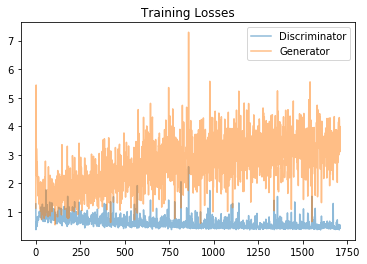

In [25]:
fig, ax = plt.subplots()
losses = np.array(losses)
plt.plot(losses.T[0], label='Discriminator', alpha=0.5)
plt.plot(losses.T[1], label='Generator', alpha=0.5)
plt.title("Training Losses")
plt.legend()

## Generator samples from training

View samples of images from the generator, and answer a question about the strengths and weaknesses of your trained models.

In [26]:
# helper function for viewing a list of passed in sample images
def view_samples(epoch, samples):
    fig, axes = plt.subplots(figsize=(16,4), nrows=2, ncols=8, sharey=True, sharex=True)
    for ax, img in zip(axes.flatten(), samples[epoch]):
        img = img.detach().cpu().numpy()
        img = np.transpose(img, (1, 2, 0))
        img = ((img + 1)*255 / (2)).astype(np.uint8)
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)
        im = ax.imshow(img.reshape((32,32,3)))

In [27]:
# Load samples from generator, taken while training
with open('train_samples.pkl', 'rb') as f:
    samples = pkl.load(f)

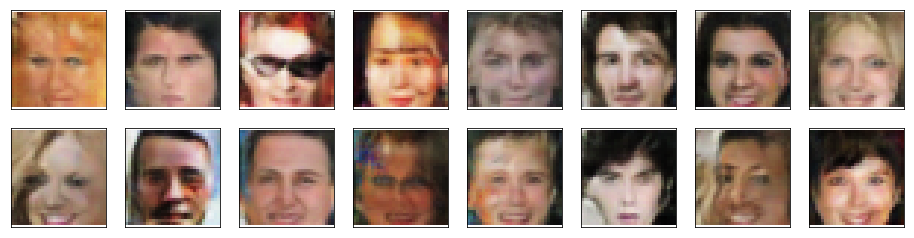

In [28]:
_ = view_samples(-1, samples)

### Question: What do you notice about your generated samples and how might you improve this model?
When you answer this question, consider the following factors:
* The dataset is biased; it is made of "celebrity" faces that are mostly white
* Model size; larger models have the opportunity to learn more features in a data feature space
* Optimization strategy; optimizers and number of epochs affect your final result


**Answer:** <br> 
I believe adding more diversity to the model will help it train <br>
Also I have read that adding more fc layer can speed up to process and get better results, <br>
like I saw in [StyleGAN](https://www.gwern.net/Faces)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "problem_unittests.py" files in your submission.